# PoPs Workflow

Polygenic Priority Score (PoPS) evaluates the associations between traits and genes, aiming to prioritizing the causal genes for complex biological traits. It incorporates GWAS summary statistics with gene expression, biological pathway, and predicted protein-protein interaction data. This pipeline is modified from the FinucaneLab's code ([Gene_features](https://github.com/FinucaneLab/gene_features/tree/master/code) and [PoPs](https://github.com/FinucaneLab/pops)). 

> [Weeks, E. M., Ulirsch, J. C., Cheng, N. Y., Trippe, B. L., Fine, R. S., Miao, J., ... & Finucane, H. K. (2020). Leveraging polygenic enrichments of gene features to predict genes underlying complex traits and diseases. medRxiv.](https://doi.org/10.1101/2020.09.08.20190561)

## Method

### Primary GLS model 

$$y=X^f\beta^f+\varepsilon,\ \ \varepsilon\sim MNV(0,R)$$

For the primary step, PoPS takes GWAS summary statistics (gene-level z scores from magma) as y and gene features extracted from gene expression, biological pathways, and predicted PPI networks as x, building a Generalized Least Squares (GLS). The model accounts for the correlation between genes by variance covariance matrix R.

### Final GLS model 

$$y=C\alpha+X^f\beta^f+\varepsilon,\ \ \varepsilon\sim MNV(0,R)$$

After fitting the primary GLS model, PoPS filters gene featues by marginal selection. For the remianing features, a final GLS model is built by Leave One Chomosome Out (LOCO) framework and ridge penalty. For each gene $g$ on the chromosome $i$, it estimates the coefficient for each remianing gene feature $\hat{\beta}_{-chr i}$. The model also incorporates a term $C\alpha$ for gene covariants (i.e. gene length, effective gene size).

### PoPS calculation

$$\hat{y}_{g}=X_{g}\hat{\beta}_{-chr i}$$

For the gene $g$ on the chromosome $i$, he Polygenic Priority Score $\hat{y}$ equals to $X_{g}$ times $\hat{\beta}_{-chr i}$. It prioritizes the genes associated with traits in a way that incorporates both locus-based and similarity-based methods.

![image.png](https://github.com/UxxUnet/prototype/blob/main/Picture1.png?raw=true)

## Overview

### Step 1 - MAGMA

#### Inputs
        
  - Reference panel

    `--bfile` A binary PLINK format data set, consisting of a .bed, .bim and .fam trio of files, is required for the reference panel. If you don't have your own bfiles, the magma's bfiles are recommended, which can be downloaded on [magma page](https://ctg.cncr.nl/software/magma). For example, build 38 can use [NCBI38](https://ctg.cncr.nl/software/MAGMA/aux_files/NCBI38.zip). Also, the reference gene locations of the sub-populations are available as well on [magma page](https://ctg.cncr.nl/software/magma), which extract specific sub-populations from the 1,000 Genomes data files. For example, for European genome, you can use [1000G.EUR.bed/bim/fam](https://ctg.cncr.nl/software/MAGMA/ref_data/g1000_eur.zip). The `1000G.EUR.mini.bed/bim/fam` files in the minimal working example only contain the necessary reference panel data for Europeans in the 1000 Genomes Project phase 3. 

  - SNP-gene location annotation

    `--gene_annot` The MAGMA SNP-gene location annotation file is created by running MAGMA with the `--annotate` flag. Each row of the MAGMA annotation file corresponds to a gene and containings the gene ID, a specification of the gene's location, and a list of SNP IDs of SNPs mapped to that gene. The `magma_0kb.genes.annot` file is a MAGMA annotation file for the 18,383 protein coding genes using SNPs in the 1000 Genomes phase 3 reference panel and a 0 Kb window around the gene body. You can also customize SNP-gene location annotation file by Step 1 optional `[annotate]` with different reading windows and reference panel.

  - GWAS summary statistics

    `--pval` the GWAS summary statistics file. It should at least contain two columns for SNP id (or concordant ids that can be found in the reference file and ) and P value. Also, the sample size is needed. If it designates the name of the column containing the per SNP sample size, use `--ncol <colname>`. Or you assign a sample size for all SNPs by `--n <int>`

#### Outputs

  - `.genes.out` file
  
    The `.genes.out` file contains the MAGMA gene analysis results in human-readable format. This file contains the gene z-scores and relevant data to construct the control covariates in the joint prediction model.

  - `.genes.raw` file
  
    The `.genes.raw` file is the intermediary file that serves as the input for subsequent analyses. This file contains the required data to consturct the gene-gene correlation matrix.
    
### Step 1 optional - Annotation

It produces a customized SNP-gene location annotation that can be used in the step 1 `[magma]`.

#### Inputs

  - SNP location file
  
     `--snp_loc` A binary PLINK format .bim indicates the SNP id and their position.
    
  - Gene location file
  
     `--gene_loc` The file indicates the gene symbol and its start and end position.
    
  - Reading windows
  
     `--winup` and `--windown`. The reading windows are optional. For default, only SNPs within gene's start and end position would be mapping to that gene. Optionally, SNPs near a gene but outside its transcription region can be mapped to that gene as well by specifying an annotation window around the genes. SNPs in that window will be annotated to that gene as well. In this way nearby SNPs still relevant to that gene can be included in that gene. However, SNPs not relevant to that gene may be included in this way as well, so it is advisable to keep this window small. For some researchers, upstream 5 kb and downstream 1.5 kb is an acceptable option.
     
#### Output

  - `.genes.annot` file
  
     It's a customized SNP-gene location annotation that can be used in the step 1 `[magma]`.

### Step 2 - Gene features

The gene features are extracted from the gene expression data (RNAseq). If you don't have the gene expression data you want to incorporate, you can also use the full feature package PoPS paper provided, then you can skip step 2. The full feature package `PoPS.features.txt.gz` can be found in `/mnt/mfs/statgen/guangyou/data/pops-MWE/`, which contains millions of features obtained from gene expression matrices, biological pathways, and predicted PPI networks.

* Read in, QC, filter, scale, and normalize data

* Perform PCA and independent component analysis (ICA) across all cells or meta-cells or tissues

* Perform clustering and UMAP and plot features on projection

* Perform differential expression analysis

#### Inputs

  - Gene expression
  
     `--expr-matrix` The RNA-seq data for the gene expression
     
  - Mata data
  
     `--meta` Additional cell-level metadata to add to the Seurat object. Should be a data frame where the rows are cell names and the columns are additional metadata fields.

  - Gene annotations
  
     `--anno_file`  The gene ENSG id, chr, position and TSS annotations
     
  - Gene symbol
  
     `--symbol` For gene ENSG id to symbol transfering

#### Output

  - Unweighted gene loadings from PCA
  
    `/features/human_airway_projected_pcaloadings.txt.gz`
    
  - Unweighted gene loadings from ICA 
  
    `/features/human_airway_projected_icaloadings.txt.gz`
    
  - Unweighted gene loadings from PCA within cluster 
  
    `features/human_immune/projected_pcaloadings_clusters.txt.gz`
    
  - Average expression across clusters (pre-defined and identified) 
  
    `/features/human_airway_average_expression.txt`
  
  - One-vs-all t-test statistic (pre-defined and identified) 
  
    `/features/human_airway_diffexprs_tstat_clusters.txt`
  
  - Differentially expressed genes across clusters (pre-defined and identified) 
  
    `/features/human_airway_diffexprs_genes_clusters.txt`

### Step 3 - Feature selection

#### Inputs

  - Gene features
  
    `--features` The gene feature file incoprates the features from gene expression (from `[genefeature]`), biological pathway, and predicted protein-protein interaction data.
     
  - Gene association results
  
    `--gene_results` The gene association results produced from `[magma]`


#### Output

  - Selected features
  
    `.features file` It contains the names of the marginally selected features. This file has no header and contains the name of one feature per row.
  

### Step 4 - Predict scores

#### Inputs

  - Gene location file
  
     `--gene_loc` The gene location file

  - Gene association results
  
     `--gene_results` The gene association results produced from `[magma]`
     
  - Gene features
  
     `--features` The gene feature file incoprates the features from gene expression (from `[genefeature]`), biological pathway, and predicted protein-protein interaction data.
     
  - Selected features

    `.selected_features` The selected features produced from `[feature_selection]`

  - Control fetures
  
     `--control_features` The list of control fetures

  - Chromosome index
  
     `--chromosome` This flag designates the chromosome for which to compute PoP scores.

#### Output

  - `.{chomosome}.results` file
  
    The `.results` file contains the predicted PoP scores for each gene on the designated chromosome.

  - `.{chomosome}.coefs` file
  
    The `.coefs` file contains the estimated $\hat{\beta}$ for each feature from fitting the PoPS model leaving out the designated chromosome.

## Next step
#### [genefeature] 
 - Need more customized options
     - Known genes set or an omit option
     - Number of PCs applied
     - Number of features to select as top variable features
     - Value of the resolution parameter
     - Cell type label in the meta data
     - PlotAndSaveDEGenesOnUMAP --height
     - Annotation symbol, i.e. human_symbol
 
#### Docker image
 - Warning "gzip: ./features/human_retina2_average_expression.txt: No such file or directory"
 
#### New steps
 - An appropriate Manhattan plot for magma p value with optional annotations 
 - An appropriate plot for PoPS score

In [12]:
sos run pops.ipynb -h

usage: sos run pops.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  annotate
  magma
  genefeature
  feature_selection
  predict_scores

Global Workflow Options:
  --cwd VAL (as path, required)
                        the code directory
  --out VAL (as path, required)
                        Path directory or prefix for output files
  --job-size 1 (as int)
                        For cluster jobs, number commands to run per job
  --walltime 5h
                        Wall clock time expected
  --mem 16G
                        Memory expected
  --numThreads 20 (as int)
                        Number of threads
  --container-pops 'guangyou/pops:1.0.0'
                        Soft

## A minimal working example

The data can be downloaded from [google drive](https://drive.google.com/drive/folders/19pjbPRfIbF8mF9ws1JNyXZqVAF1oa9zx), or can be found in the cluster folder `/mnt/mfs/statgen/guangyou/data/pops-MWE/`, including the dependent R file `utils.R`. The container `pops.sif` can be found on the cluster folder `/mnt/mfs/statgen/guangyou/containers/`.

In [5]:
sos run pops.ipynb annotate\
    --cwd ~/pops/code/\
    --snp_loc /mnt/mfs/statgen/guangyou/data/pops-MWE/1000G.EUR.mini.bim\
    --gene_loc /mnt/mfs/statgen/guangyou/data/pops-MWE/NCBI38.gene.loc\
    --winup 5\
    --windown 1.5\
    --container_pops /mnt/mfs/statgen/guangyou/containers/pops.sif\
    --out ~/pops/out/1000G.EUR.mini

INFO: Running annotate: Get annotation for mapping SNPs to genes by magma
INFO: annotate is completed.
INFO: annotate output:   /home/gl2776/pops/out/1000G.EUR.mini.genes.annot
INFO: Workflow annotate (ID=we916f2e05ac9b3e1) is executed successfully with 1 completed step.



In [7]:
sos run pops.ipynb magma\
    --cwd ~/pops/code/ \
    --bfile ~/pops/data/1000G.EUR.mini.bed\
    --gene_annot ~/pops/data/magma_0kb.genes.annot\
    --pval ~/pops/data/AFib-mini.tbl\
    --snpcol rs_dbSNP147\
    --pvalcol Pvalue\
    --n 60620\
    --ncol \
    --container_pops /mnt/mfs/statgen/guangyou/containers/pops.sif\
    --out ~/pops/out/AFib-mini

INFO: Running magma: Get gene-level z scores
INFO: magma is completed.
INFO: magma output:   /home/gl2776/pops/out/AFib-mini.genes.out /home/gl2776/pops/out/AFib-mini.genes.raw
INFO: Workflow magma (ID=w094bfb34d87c271a) is executed successfully with 1 completed step.



In [2]:
sos run pops.ipynb genefeature\
    --cwd ~/pops/code/ \
    --expr_matrix ~/pops/data/GSE137537_counts.mtx.tsv.gz \
    --meta ~/pops/data/GSE137537_sample_annotations.tsv.gz \
    --anno_file ~/pops/resources/gene_annot_jun10.txt \
    --symbol ~/pops/resources/ensg2symbol.txt \
    --ppath ~/pops/data/PoPS.features.ppiandpathways.mini.txt \
    --container_pops /mnt/mfs/statgen/guangyou/containers/pops.sif \
    --util_src ~/pops/code/utils.R \
    --name human_retina2 \
    --out ~/pops/out/

INFO: Running genefeature_1: To extract the gene features from gene expression data
INFO: genefeature_1 is completed.
INFO: genefeature_1 output:   /home/gl2776/pops/out/plots/human_retina2_variablegenes.pdf /home/gl2776/pops/out/plots/human_retina2_pcaelbow.pdf... (10 items)
INFO: Running genefeature_2: To merge the gene features from gene expression data produced by [genefeature_1] with PPi and pathways features
INFO: genefeature_2 (index=0) is ignored due to saved signature
INFO: genefeature_2 output:   /home/gl2776/pops/out/human_retina2_merge.gene.features.txt /home/gl2776/pops/out/human_retina2_merge.all.features.txt
INFO: Workflow genefeature (ID=wf0d1ad89f4490794) is executed successfully with 1 completed step and 1 ignored step.



![image.png](https://github.com/UxxUnet/prototype/blob/main/human_retina2_pcaelbow.pdf.png?raw=true)

![image.png](https://github.com/UxxUnet/prototype/blob/main/human_retina2_umap_clusters.pdf.png?raw=true)

In [9]:
sos run pops.ipynb feature_selection\
    --cwd ~/pops/code/\
    --features ~/pops/out/human_retina2_merge.all.features.txt\
    --gene_results ~/pops/out/AFib-mini.genes.out\
    --container_pops /mnt/mfs/statgen/guangyou/containers/pops.sif\
    --out ~/pops/out/AFib-mini

INFO: Running feature_selection: Feature selection by the GLS model
INFO: feature_selection is completed.
INFO: feature_selection output:   /home/gl2776/pops/out/AFib-mini.features
INFO: Workflow feature_selection (ID=w880481d548b6ef61) is executed successfully with 1 completed step.



In [11]:
sos run pops.ipynb predict_scores\
    --cwd ~/pops/code/\
    --gene_loc ~/pops/data/gene_loc.txt\
    --gene_results ~/pops/out/AFib-mini.genes.out\
    --features ~/pops/out/human_retina2_merge.all.features.txt\
    --selected_features ~/pops/out/AFib-mini.features\
    --control_features ~/pops/data/control.features\
    --chromosome 1\
    --container_pops /mnt/mfs/statgen/guangyou/containers/pops.sif\
    --out ~/pops/out/AFib-mini

INFO: Running predict_scores: Polygenic Priority Score calculation
INFO: predict_scores (index=0) is ignored due to saved signature
INFO: predict_scores output:   /home/gl2776/pops/out/AFib-mini.1.results /home/gl2776/pops/out/AFib-mini.1.coefs
INFO: Workflow predict_scores (ID=wbbb019bc751789ec) is ignored with 1 ignored step.



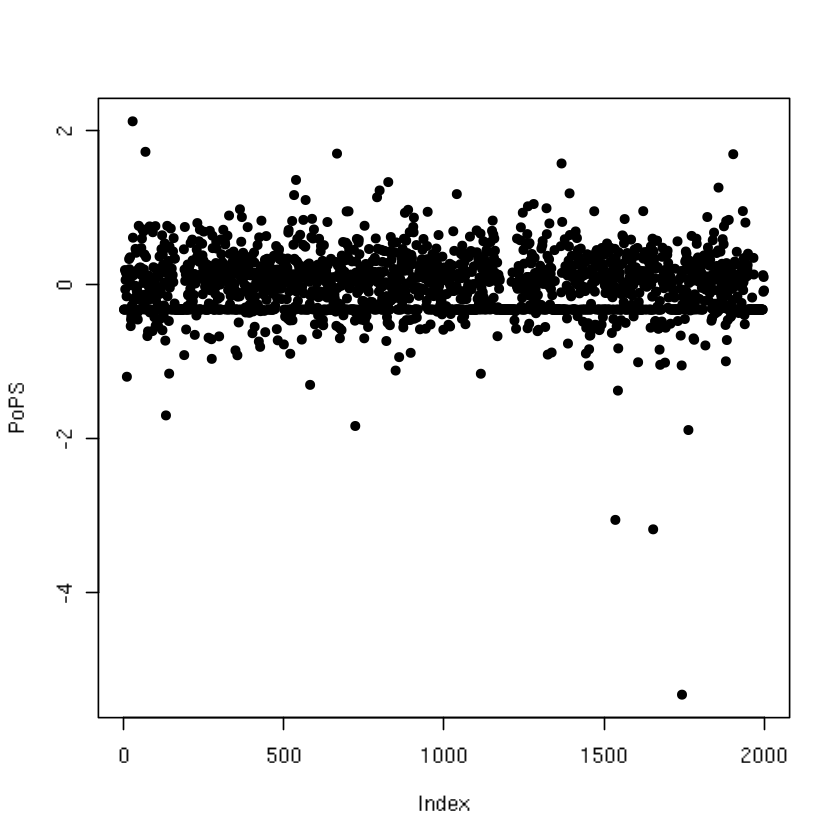

In [6]:
data<-read.table("~/pops/out/AFib-mini.1.results",header=T)
plot(data$Score,ylab="PoPS",pch=16)

In [ ]:
[global]
# the code directory
parameter: cwd = path
# Path directory or prefix for output files
parameter: out = path
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 20
# Software container option
parameter: container_pops = 'guangyou/pops:1.0.0'
cwd = f"{cwd:a}"

In [ ]:
# Get annotation for mapping SNPs to genes by magma
[annotate]
# Path to SNP locations file, usually from the genotype (reference) plink data, such as .bim
parameter: snp_loc = path
# Path to reference gene location file
parameter: gene_loc = path
# The size (kb) of the upstream (towards 5’ end) window
parameter: winup = -1
# The size (kb) of the downstream (towards 3’ end) window. It should be set together with 'winup' and keep they non-negetive
parameter: windown = float
input: snp_loc, gene_loc
output: f'{out}.genes.annot'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_pops, expand= "${ }", stderr = f'{out}_annotate.stderr', stdout = f'{out}_annotate.stdout' 
    magma \
      --annotate ${('window=%d,%d' %(winup,windown)) if winup >=0 else ('')}\
      --snp-loc ${_input[0]:r} \
      --gene-loc ${_input[1]:r} \
      --out ${_output:nn}

In [ ]:
# Get gene-level z scores
[magma]
# Path of the plink format file set for the reference panel, including .bed/.fam/.bim
parameter: bfile = paths
# Path to MAGMA gene annotation file
parameter: gene_annot = path
# Path to summary statistics file
parameter: pval = path
# The colname (or name) of SNP id in summary statistics file
parameter: snpcol = str
# The colname (or name) of p value id in summary statistics file
parameter: pvalcol = str
# The sample size
parameter: n = 0
# The column name in pval file for per sample size . Please use only one of "n" and "ncol" and leave the other empty
parameter: ncol = str
# Path prefix for output. MAGMA will append .genes.out and .genes.raw to this prefix.
parameter: out = path
input: bfile, gene_annot, pval
output: f'{out}.genes.out', f'{out}.genes.raw'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_pops, expand= "${ }", stderr = f'{out}_magma.stderr', stdout = f'{out}_magma.stdout' 
    magma \
      --bfile ${_input[0]:n} \
      --gene-annot ${_input[1]:r} \
      --pval  ${_input[2]:r} use=${snpcol},${pvalcol} ${('N=%d' %n) if n > 0 else ('ncol=%s' %ncol)} \
      --gene-model snp-wise=mean \
      --out ${_output[0]:nn} 

In [13]:
# To extract the gene features from gene expression data 
[genefeature_1]
# Path to expression matrix file
parameter: expr_matrix = path
# Path to the meta data information tsv file 
parameter: meta = path
# Path to the annotation file 
parameter: anno_file = path
# Path to the symbol file 
parameter: symbol = path
# A string to identify your analysis run
parameter: name = str
# Number of PCs applied
parameter: number_pcs = 30
# Number of features to select as top variable features
parameter: vargenes = 1500
# Value of the resolution parameter, use a value above (below) 1.0 if you want to obtain a larger (smaller) number of communities
parameter: clus_res = 0.3
# Path to a dependent R file 
parameter: util_src = path
# Path prefix for output. MAGMA will append .genes.out and .genes.raw to this prefix.
parameter: out = path
input: expr_matrix, meta, anno_file, symbol
output: f'{out}/plots/{name}_variablegenes.pdf',
        f'{out}/plots/{name}_pcaelbow.pdf',
        f'{out}/plots/{name}_umap_clusters.pdf',
        f'{out}/plots/{name}_umap_clusters_pre_def.pdf',
        f'{out}/plots/{name}_umap_pcs.pdf',
        f'{out}/plots/{name}_umap_ics.pdf',
        f'{out}/plots/{name}_umap_knownmarkers.pdf',
        f'{out}/plots/{name}_umap_degenes.pdf',
        f'{out}/plots/{name}_umap_degenes_pre_def.pdf',
        f'{out}/features/{name}_so.rds'
task: trunk_workers = 1, walltime = "10h", mem = "24G", cores = 24, tags = f'{step_name}_{name}'
R:  container=container_pops, expand= "${ }", stderr = f'{out}/{name}_genefeature_1.stderr', stdout = f'{out}/{name}_genefeature_1.stdout' 
    library(tidyverse)
    library(data.table)
    library(BuenColors)
    library(Seurat)
    library(irlba)
    library(Matrix)
    library(future)
    library(reticulate)
    library(ggrastr)
    library(tidytext)
    library(matrixTests)
    # Need a function source file, or the code would be too long
    source("${util_src}")
    # Set up parallelization
    # Remember to use htop to delete forgotten forks
    Sys.setenv(R_FUTURE_FORK_ENABLE = T)
    options(future.globals.maxSize = 6 * 2048 * 1024^2)
    # plan(strategy = "multicore", workers = 32)
    name <- "${name}"
    # Setup dictionary
    dir.create("${out:r}/plots/")
    dir.create("${out:r}/features/")
    # Notes on data:
    # Annotations provided. There is a mild batch effeect by method, but correcting it breaks the clustering.
    # So we ignore it. Looking at pre-defined clusters, we are clearly still capturing biology.
    ### Assumes a sparse dgCMatrix as input
    ### Accepts row_id_type = ENSG, ENSMUSG, human_symbol, mouse_symbol
    #------------------------------------------------LOAD AND FORMAT DATA-----------------------------------------------#
    # Read in data and annotations
    mat <- data.frame(fread(${_input[0]:r}), row.names=1) %>%
      data.matrix() %>%
      Matrix(sparse = TRUE) %>%
      as("dgCMatrix")
    mat.annot <- data.frame(fread(${_input[1]:r}, header=T), row.names=1)
    colnames(mat) <- rownames(mat.annot)

    # Convert to ENSG, drop duplicates, and fill in missing genes
    mat <- ConvertToENSGAndProcessMatrix(mat, "human_symbol", "${_input[3]:d}", ${_input[2]:r})

    # Load this in in case we need it later
    keep <- read.table(${_input[2]:r}, sep = "\t", header = T, stringsAsFactors = F, col.names = c("ENSG", "symbol", "chr", "start", "end", "TSS"))

    #--------------------------------------------------COMPUTE FEATURES-------------------------------------------------#

    # Create Seurat object
    # min.features determined for each dataset
    so <- CreateSeuratObject(counts = mat, project = name, min.features = 200, meta.data = mat.annot)

    # Clean up
    rm(mat)

    # QC
    so <- subset(so, 
                 subset = nFeature_RNA > quantile(so$nFeature_RNA, 0.05) & 
                   nFeature_RNA < quantile(so$nFeature_RNA, 0.95))
    so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 1000000)
    so <- ScaleData(so, min.cells.to.block = 1, block.size = 500)

    # Identify variable genes
    so <- FindVariableFeatures(so, nfeatures = ${vargenes})

    # Plot variable genes with and without labels
    PlotAndSaveHVG(so, ${_output[0]:r})
    
    # Run PCA
    so <- RunPCA(so, npcs = 100)
    # Project PCA to all genes
    so <- ProjectDim(so, do.center = T)
    # Plot Elbow
    PlotAndSavePCAElbow(so, 100, ${_output[1]:r})

    # Run ICA
    so <- RunICA(so, nics = ${number_pcs})
    # Project ICA to all genes
    so <- ProjectDim(so, reduction = "ica", do.center = T)

    # Cluster cells
    so <- FindNeighbors(so, dims = 1:${number_pcs}, nn.eps = 0)
    so <- FindClusters(so, resolution = ${clus_res}, n.start = 100)

    # UMAP dim reduction
    so <- RunUMAP(so, dims = 1:${number_pcs}, min.dist = 0.4, n.epochs = 500,
                  n.neighbors = 10, learning.rate = 0.1, spread = 2)

    # Plot UMAP clusters
    PlotAndSaveUMAPClusters(so, so@meta.data$seurat_clusters, ${_output[2]:r})
    # Plot known clusters on UMAP (if applicable)
    PlotAndSaveUMAPClusters(so, so@meta.data$Labels, ${_output[3]:r})

    # Plot PCs on UMAP
    PlotAndSavePCsOnUMAP(so, ${_output[4]:r})
    # Plot ICs on UMAP
    PlotAndSaveICsOnUMAP(so, ${_output[5]:r})
    # Plot known marker genes on UMAP 
    marker_genes <- c("PDE6A", "PPEF2", "NR2E3", "GNAT2", "OPN1MW", "OPN1LW", "NEFM", "NEFM", "SNCG", "CAD1", "C1QL2", "LHX1", "CLU", "CLUL", "APOE", "TMEM119", "AIF1", "CD163", "ADAMTS9", "CD34", "CDH5", "RGS5")
    PlotAndSaveKnownMarkerGenesOnUMAP(so, keep, marker_genes, ${_output[6]:r})
  
    # Save global features
    featurepathprefix=paste0("${out}/features/","${name}","_")
    SaveGlobalFeatures(so, featurepathprefix)

    # Compute any cluster dependent features (DE genes, within-cluster PCs, etc.) and save them
    # Seurat clusters
    Idents(object=so) <- "seurat_clusters"
    clus <- levels(so@meta.data$seurat_clusters)
    demarkers <- WithinClusterFeatures(so, "seurat_clusters", clus, featurepathprefix)

    # Pre-defined cluster dependent features (if applicable)
    Idents(object=so) <- "Labels"
    clus <- unique(so@meta.data$Labels)
    demarkers_pre_def <- WithinClusterFeatures(so, "Labels", clus, featurepathprefix, suffix = "_pre_def")
    
    # Plot DE genes on UMAP
    PlotAndSaveDEGenesOnUMAP(so, demarkers, ${_output[7]:r}, height = 15, rank_by_tstat = TRUE)
    # Plot DE genes from pre-defined clusters on UMAP (if applicable)
    PlotAndSaveDEGenesOnUMAP(so, demarkers_pre_def, ${_output[8]:r}, height = 15, rank_by_tstat = TRUE)

    # Save Seurat object
    saveRDS(so, ${_output[9]:r})

In [ ]:
# To merge the gene features from gene expression data produced by [genefeature_1] with PPi and pathways features
[genefeature_2]
# This flag gives the prefix for location of the gene association results from [magma]
parameter: ppath = path
# A string to identify your analysis run
parameter: name = str
input: ppath
output: f'{out}/{name}_merge.gene.features.txt',
        f'{out}/{name}_merge.all.features.txt'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
python: container=container_pops, expand= "${ }", stderr = f'{out}/{name}_genefeature_2.stderr', stdout = f'{out}/{name}_genefeature_2.stdout' 
    import pandas as pd
    import os 
    # Gene expression features read in and merge
    path="${out}/features/"
    name="${name}"
    files = [f for f in os.listdir(path) if f.endswith(".txt")]
    feature_df=pd.read_csv(os.path.join(path,files[0]),sep="\t")
    feature_df=feature_df.add_prefix("%s_"%files[0].split(".")[0])
    feature_df=feature_df.rename(columns={"%s_ENSG"%files[0].split(".")[0]:"ENSG"})
    for i in range(1,len(files)):
        x=pd.read_csv(os.path.join(path,files[i]),sep="\t")
        x=x.add_prefix("%s_"%files[i].split(".")[0])
        x=x.rename(columns={"%s_ENSG"%files[i].split(".")[0]:"ENSG"})
        feature_df=feature_df.merge(x, on='ENSG', how='inner')
    feature_df=feature_df.rename(columns={"ENSG":"ENSGID"})
    feature_df.to_csv(${_output[0]:r},sep="\t",index=False)
    # PPI and Pathways features read in and merge
    ppath=${_input:r}
    pfeatures=pd.read_csv(os.path.join(ppath),sep="\t")
    feature_df=feature_df.merge(pfeatures, on='ENSGID', how='inner')
    feature_df.to_csv(${_output[1]:r},sep="\t",index=False)

In [ ]:
# Feature selection by the GLS model
[feature_selection]
# Path to the gene feature file
parameter: features = path
# This flag gives the prefix for location of the gene association results from [magma]
parameter: gene_results = path
# Path prefix for output. It will append .features to this prefix.
parameter: out = path
input: features, gene_results
output: f'{out}.features'
task: trunk_workers = 1, walltime = '10h', mem = '20G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_pops, expand= "${ }", stderr = f'{out}_feature_selection.stderr', stdout = f'{out}_feature_selection.stdout' 
    pops.feature_selection.py\
      --features ${_input[0]:r}\
      --gene_results ${_input[1]:nn}\
      --out ${_output:n}

In [ ]:
# Polygenic Priority Score calculation
[predict_scores]
# Path to the gene location file 
parameter: gene_loc = paths
# This flag gives the prefix for location of the gene association results from [magma]
parameter: gene_results = path
# Path to the gene feature file
parameter: features = path
# This flag gives the prefix for the location of the list of selected features from [feature_selection]
parameter: selected_features = path
# Path to the list of control fetures
parameter: control_features = path
# The index of chromosome for which to compute PoP scores
parameter: chromosome = int
input: gene_loc, gene_results, features, selected_features, control_features
output: f'{out}.{chromosome}.results',f'{out}.{chromosome}.coefs'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_pops, expand= "${ }", stderr = f'{out}_predict_scores.stderr', stdout = f'{out}_predict_scores.stdout'
    pops.predict_scores.py\
      --gene_loc ${_input[0]:r}\
      --gene_results ${_input[1]:nn}\
      --features ${_input[2]:r}\
      --selected_features ${_input[3]:r}\
      --control_features ${_input[4]:r}\
      --chromosome ${chromosome}\
      --out ${_output[0]:nn}